<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/DENOISED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
!pip install pandas_ta

In [18]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import tensorflow as tf
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten, LSTM
from tensorflow.keras.utils import to_categorical

In [19]:
df = pd.read_csv('/content/drive/MyDrive/eurusd_hour.csv')
close = df['AC']
open = df['AO']
high = df['AH']
low = df['AL']
change = df['ACh']
print(df)

             Date   Time       BO       BH       BL       BC      BCh  \
0      2005-05-02  00:00  1.28520  1.28520  1.28400  1.28440 -0.00080   
1      2005-05-02  01:00  1.28440  1.28480  1.28390  1.28420 -0.00020   
2      2005-05-02  02:00  1.28430  1.28540  1.28410  1.28510  0.00080   
3      2005-05-02  03:00  1.28510  1.28590  1.28500  1.28510  0.00000   
4      2005-05-02  04:00  1.28520  1.28590  1.28490  1.28550  0.00030   
...           ...    ...      ...      ...      ...      ...      ...   
93079  2020-04-29  18:00  1.08620  1.08851  1.08611  1.08713  0.00093   
93080  2020-04-29  19:00  1.08711  1.08823  1.08659  1.08748  0.00037   
93081  2020-04-29  20:00  1.08747  1.08788  1.08691  1.08708 -0.00039   
93082  2020-04-29  21:00  1.08708  1.08740  1.08699  1.08714  0.00006   
93083  2020-04-29  22:00  1.08728  1.08760  1.08727  1.08743  0.00015   

            AO       AH       AL       AC      ACh  
0      1.28540  1.28540  1.28420  1.28460 -0.00080  
1      1.28460  1

In [20]:
df['Date'] = pd.to_datetime(df['Date'])
df['Time'] = pd.to_datetime(df['Time'])

Date_df = pd.DataFrame({
       'Month': df['Date'].dt.month / 12,  # Divide by 12 to normalize the values between 0 and 1
       'Day': df['Date'].dt.day / 31,  # Divide by 31 to normalize the values between 0 and 1
       'Hour': df['Time'].dt.hour / 24,  # Divide by 24 to normalize the values between 0 and 1
       'DayOfWeek': df['Date'].dt.dayofweek / 6  # Divide by 6 to normalize the values between 0 and 1
   })

In [21]:
def compare_arrays(arr1, arr2):
    result = []
    for i in range(len(arr1)):
        if arr1[i] > arr2[i]:
            result.append(1)
        else:
            result.append(0)
    return result

In [45]:
def cross_over_under(arr):
    result = np.zeros_like(arr)
    for i in range(1, len(arr)):
        if arr[i] > arr[i-1] and not arr[i-2] < arr[i-1]:
            result[i] = 1
        elif arr[i] < arr[i-1] and not arr[i-2] > arr[i-1]:
            result[i] = 2


    return result

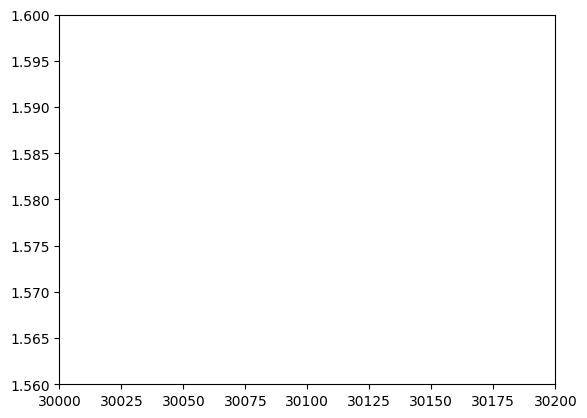

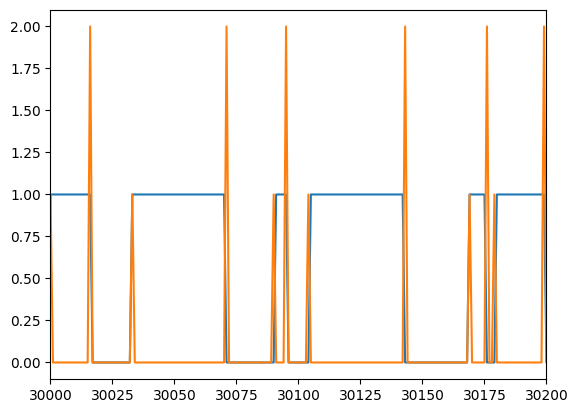

In [46]:
SMA = ta.sma(close,4,offset=-2)
filter = gaussian_filter1d(close, sigma=4)
test = cross_over_under(filter)
filter2 = np.roll(filter,2)
classs = compare_arrays(filter,filter2)
NOISE = close-filter
BAR_SIZE = high-low
OPEN_SIZE = open - low
CLOSE_SIZE = close - low

plt.xlim(30000,30200)
plt.ylim(1.56,1.6)
plt.plot(filter)
plt.plot(filter2)
plt.plot(close)
plt.show()
plt.xlim(30000,30200)
plt.plot(classs)
plt.plot(test)
plt.show()

In [23]:
# Define the window length and stride
window_length = 20
stride = 1

month = Date_df['Month']
day = Date_df['Day']
hour = Date_df['Hour']
dotw = Date_df['DayOfWeek']
changed = pd.Series(change,name='change')
NOISED = pd.Series(NOISE,name='noise')
combined_series = pd.concat([changed,NOISED,month,day,hour,dotw], axis=1)
combined_series = combined_series.dropna(axis=0)
print(combined_series)
noise = combined_series.pop('noise')
changed = combined_series.pop('change')
month = combined_series.pop('Month')
day = combined_series.pop('Day')
hour = combined_series.pop('Hour')
dotw = combined_series.pop('DayOfWeek')

# Create the sliding window view for time_series_1
changed = sliding_window_view(changed, window_length)[::stride]
NOISED = np.roll(noise, -window_length)
NOISED = NOISED[:changed.shape[0]]
month = np.expand_dims(month[:changed.shape[0]],1)
day = np.expand_dims(day[:changed.shape[0]],1)
hour = np.expand_dims(hour[:changed.shape[0]],1)
dotw = np.expand_dims(dotw[:changed.shape[0]],1)


changed = changed/np.std(changed)
NOISED = NOISED/np.std(NOISED)
print(changed)

        change     noise     Month       Day      Hour  DayOfWeek
0     -0.00080 -0.000579  0.416667  0.064516  0.000000   0.000000
1     -0.00020 -0.000822  0.416667  0.064516  0.041667   0.000000
2      0.00080 -0.000004  0.416667  0.064516  0.083333   0.000000
3      0.00000 -0.000117  0.416667  0.064516  0.125000   0.000000
4      0.00030  0.000151  0.416667  0.064516  0.166667   0.000000
...        ...       ...       ...       ...       ...        ...
93079  0.00066  0.000543  0.333333  0.935484  0.750000   0.333333
93080  0.00035  0.000688  0.333333  0.935484  0.791667   0.333333
93081  0.00050  0.001004  0.333333  0.935484  0.833333   0.333333
93082 -0.00042  0.000467  0.333333  0.935484  0.875000   0.333333
93083  0.00004  0.000345  0.333333  0.935484  0.916667   0.333333

[93084 rows x 6 columns]
[[-0.51753957 -0.12938489  0.51753957 ... -0.19407734  0.5498858
   0.25876979]
 [-0.12938489  0.51753957  0.         ...  0.5498858   0.25876979
   0.29111601]
 [ 0.51753957  0.    

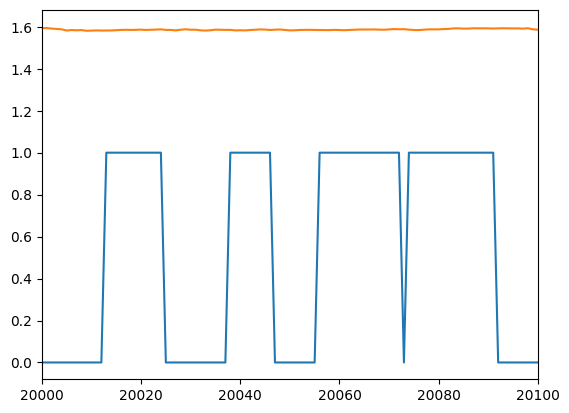

In [24]:

#print(changed[:, ])
#print(NOISED)


plt.xlim(20000,20100)
plt.plot(classs)
plt.plot(close)


In [25]:
def activity_regularizer(multiplier, decay=0.99):
    # Initialize moving averages for mean and variance
    mean_avg = tf.Variable(0.0, trainable=False, name='mean_avg')
    variance_avg = tf.Variable(1.0, trainable=False, name='variance_avg')

    def regularizer(y_pred):
        # Calculate the current mean and variance
        current_mean = tf.reduce_mean(y_pred)
        current_variance = tf.math.reduce_variance(y_pred)

        # Update moving averages
        update_mean = tf.compat.v1.assign(mean_avg, decay * mean_avg + (1 - decay) * current_mean)
        update_variance = tf.compat.v1.assign(variance_avg, decay * variance_avg + (1 - decay) * current_variance)

        with tf.control_dependencies([update_mean, update_variance]):
            # Use the moving averages for regularization
            mean = mean_avg
            variance = variance_avg

        return multiplier * (tf.square(mean - 0) + tf.square(variance - 1))

    return regularizer

In [57]:
reg = activity_regularizer(.01)

# Create a sequential model
model = Sequential()


model.add(Dense(20, activation='gelu',activity_regularizer=reg))
model.add(Dropout(.2))
model.add(Dense(10, activation='gelu',activity_regularizer=reg))
model.add(Dropout(.2))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [58]:
X_train=changed#np.concatenate((changed,month,day,hour,dotw), axis=1)
y_train=to_categorical(test)

model.fit(X_train, y_train, epochs=100000, batch_size=64,validation_split=.2)

Epoch 1/100000
1164/1164 [==============================] - 5s 3ms/step - loss: 0.3482 - accuracy: 0.9346 - val_loss: 0.2377 - val_accuracy: 0.9452
Epoch 2/100000
1164/1164 [==============================] - 4s 3ms/step - loss: 0.2467 - accuracy: 0.9445 - val_loss: 0.2268 - val_accuracy: 0.9452
Epoch 3/100000
1164/1164 [==============================] - 3s 3ms/step - loss: 0.2356 - accuracy: 0.9445 - val_loss: 0.2235 - val_accuracy: 0.9452
Epoch 4/100000
1164/1164 [==============================] - 3s 2ms/step - loss: 0.2309 - accuracy: 0.9445 - val_loss: 0.2212 - val_accuracy: 0.9452
Epoch 5/100000
1164/1164 [==============================] - 3s 2ms/step - loss: 0.2275 - accuracy: 0.9445 - val_loss: 0.2195 - val_accuracy: 0.9452
Epoch 6/100000
1164/1164 [==============================] - 4s 3ms/step - loss: 0.2260 - accuracy: 0.9445 - val_loss: 0.2191 - val_accuracy: 0.9452
Epoch 7/100000
1164/1164 [==============================] - 5s 4ms/step - loss: 0.2248 - accuracy: 0.9445 - val_

KeyboardInterrupt: ignored

In [ ]:
changed

In [ ]:
print(X_train[0])

In [ ]:
prediction = model.predict(X_train)

In [ ]:
plt.xlim(20000,20100)
plt.plot(prediction)
plt.plot(y_train)

In [ ]:
# Set the print options
np.set_printoptions(suppress=True, precision=4)
print(model.get_weights())

In [ ]:
weights = np.array(model.get_weights(),dtype=object)
weight, bias = np.split(weights, 2)
#print(weight[1])
print(weights[1])
print(bias[1])

In [51]:
def is_numpy_array(obj):
       return type(obj) is np.ndarray

In [59]:
activation = ["gelu","gelu", "","gelu", "","AF.linear","AF.linear","AF.gelu","AF.linear"]
network = np.array(model.get_weights(),dtype=object)
# Create an array of integers from 0 to 25 representing ASCII values of lowercase letters
ascii_values = np.arange(97, 123)

# Convert the ASCII values to characters using the 'chr' function
characters = np.char.add('', np.char.mod('%c', ascii_values))

# Create an empty array to store the selected arrays
bias = np.empty_like(network[1::2])  # Create an empty array with the same shape as the selected arrays
# Create an empty array to store the selected arrays
weight = np.empty_like(network[::2])  # Create an empty array with the same shape as the selected arrays

#Iterate over the main array and select every second array
for i, arr in enumerate(network[1::2]):
    bias[i] = arr

for i, arr in enumerate(network[::2]):
    weight[i] = arr



for lay_num, layer in enumerate(weight):
  for neu_num, neuron in enumerate(np.transpose(layer)):
    if not is_numpy_array(neuron):
      neuron_makeup = str(characters[lay_num+1]) + str(neu_num) + " = ("
      neuron_makeup += str(neuron) + " * " + characters[lay_num]  + str(neu_num) + " + " +  str(bias[lay_num][neu_num]) + ")"

    else:
      neuron_makeup = str(characters[lay_num+1]) + str(neu_num) + " = " + activation[lay_num] + "("
      for mul_num, mult in enumerate(neuron):
          neuron_makeup += str(mult) + " * " +characters[lay_num] + str(mul_num) + " + "
      neuron_makeup += str(bias[lay_num][neu_num]) + ")"
    np.set_printoptions(suppress=True)
    print(neuron_makeup)

b0 = gelu(0.7046121 * a0 + 0.61224794 * a1 + 0.49473158 * a2 + 0.61984015 * a3 + 0.5264545 * a4 + 0.3525676 * a5 + 0.34904638 * a6 + 0.15714374 * a7 + 0.22673282 * a8 + 0.015247816 * a9 + 0.19549552)
b1 = gelu(-0.09655409 * a0 + -0.36730182 * a1 + -0.46404624 * a2 + -0.39289436 * a3 + -0.3168614 * a4 + -0.42765352 * a5 + -0.25485638 * a6 + -0.18915561 * a7 + -0.10771743 * a8 + -0.09860917 * a9 + 0.19340359)
b2 = gelu(-0.3509126 * a0 + -0.3796832 * a1 + -0.34756434 * a2 + -0.545025 * a3 + -0.3159147 * a4 + -0.06341022 * a5 + 0.11868501 * a6 + -0.103359625 * a7 + 0.13256359 * a8 + 0.13493483 * a9 + 0.057905234)
b3 = gelu(-0.0062242076 * a0 + -0.30068028 * a1 + 0.36497542 * a2 + -0.057179376 * a3 + -0.024628976 * a4 + 0.018079529 * a5 + -0.01799885 * a6 + 0.16416286 * a7 + 0.05245099 * a8 + 0.05464089 * a9 + 0.088542536)
b4 = gelu(0.23438933 * a0 + 0.27501264 * a1 + 0.42652407 * a2 + 0.46633178 * a3 + 0.45232728 * a4 + 0.46990892 * a5 + 0.3134805 * a6 + 0.34042504 * a7 + 0.17839618 * a8 +

In [60]:
num_of_loop = 20
for i in range(num_of_loop):
  phrase = "a" + str(num_of_loop-1-i) + "= change[" + str(i) + ']'
  print(phrase)

a19= change[0]
a18= change[1]
a17= change[2]
a16= change[3]
a15= change[4]
a14= change[5]
a13= change[6]
a12= change[7]
a11= change[8]
a10= change[9]
a9= change[10]
a8= change[11]
a7= change[12]
a6= change[13]
a5= change[14]
a4= change[15]
a3= change[16]
a2= change[17]
a1= change[18]
a0= change[19]


In [ ]:
dev = ta.stdev(close-open,1000)
change = (close-open)/dev
months = month(time)/12
days = dayofmonth(time)/31
hours = hour(time)/24
dayoftheweeks = dayofweek(time)/6

a0 = change[4]
a1 = change[3]
a2 = change[2]
a3 = change[1]
a4 = change
a5 = months
a6 = days
a7 = hours
a8 = dayoftheweeks

tanh(x) =>
    output = (math.exp(x) - math.exp(-x)) / (math.exp(x) + math.exp(-x))
//

gelu(x) =>
    cdf = 0.5 * (1 + tanh((math.sqrt(2 / math.pi) * (x + 0.044715 * math.pow(x, 3)))))
    output = x * cdf
    output
